In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import numpy as np
from PIL import Image
from random import randint

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### I. Load the datasets

In [3]:
img_dir = '/home/xiaoyu/BMMC/BMMCdata'
mask_dir = '/home/xiaoyu/BMMC/BMMCmasks'

img_list = sorted(os.listdir(img_dir))
mask_list = sorted(os.listdir(mask_dir))

print("Training images numbers: "+str(len(img_list)))
print("Training mask Images numbers:"+str(len(mask_list)))

Training images numbers: 43
Training mask Images numbers:43


In [4]:
index = randint(0,42)
image_str = img_list[index]
mask_str = mask_list[index]

image_arr = io.imread(os.path.join(img_dir, image_str))
image_arr = np.uint8(image_arr)
mask_arr = io.imread(os.path.join(mask_dir, mask_str))

image_tensor = torch.from_numpy(image_arr)
mask_tensor = torch.from_numpy(mask_arr)
print(image_tensor.size())
print(mask_tensor.size())

torch.Size([1024, 1024, 3])
torch.Size([1024, 1024])


### Define a funciton for the visualization

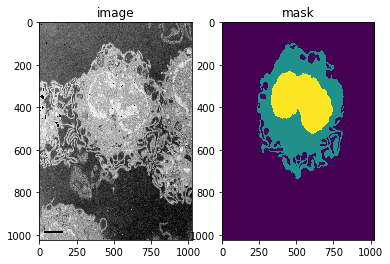

In [5]:
def show_mask(image, mask):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask, aspect='auto')
    plt.show()
    
# test the function

show_mask(image_arr, mask_arr )

#### The input image is size 1024x1024x3, and the mask size is 1024x1024
### Find the unique color in mask
The unique color in mask is 85, 170, 255, so we can consider there are 3 classes in mask, for all 85 values, we consider it to be class 0, value 170 as class 1 and value 255 as class 2

In [6]:
colors = torch.tensor([])
for i in range(len(img_list)):
    img_arr = io.imread(os.path.join(img_dir, img_list[i]))
    img_tensor = torch.from_numpy(np.uint8(img_arr))
    img_tensor = img_tensor.permute(2,0,1)
    
    mask_str = mask_list[i]
    mask_arr = io.imread(os.path.join(mask_dir, mask_str))
    mask_tensor = torch.from_numpy(mask_arr)
    unique_color = torch.unique(mask_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)

tensor([ 85., 170., 255.])


### Test the mapping

In [7]:
mapp = {1:0,
        2:1,
        3:2}
b = torch.Tensor([1,2,1,3])
for k in mapp:
    b[b == k] = mapp[k]
print(b)

tensor([0., 1., 0., 2.])


### Define the training set class

In [79]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.img_dir = img_dir
        self.transform = transform
        self.mask_dir = mask_dir
        # mapping the mask value to class value
        self.mapping = {
            85: 0,
            170: 1,
            255: 2
        }
        
    def mask_to_class(self, mask):
        for k in self.mapping:
            mask[mask==k] = self.mapping[k]
        return mask
        
    def __len__(self):
        img_list = os.listdir(self.img_dir)
        return len(img_list)
    
    def __getitem__(self, idx):
        img_list = sorted(os.listdir(img_dir))
        mask_list = sorted(os.listdir(mask_dir))
        
        img_str = img_list[idx]
        img_arr = io.imread(os.path.join(img_dir, img_str))
        img_tensor = torch.from_numpy(np.uint8(img_arr))
        img_tensor = img_tensor.permute(2,0,1)
        
        mask_str = mask_list[idx]
        mask_arr = io.imread(os.path.join(mask_dir, mask_str))
        mask_tensor = torch.from_numpy(mask_arr)
        
        mask_tensor = self.mask_to_class(mask_tensor)
      
        sample = {'image':img_tensor, 'mask':mask_tensor}
        
        if self.transform:
            mask = self.transform(torch.unsqueeze(mask_tensor,dim=0))
            mask = mask.squeeze()
            image = self.transform(img_tensor)
            sample = {'image':image, 'mask':mask}
        return sample

0 torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([3, 1024, 1024])


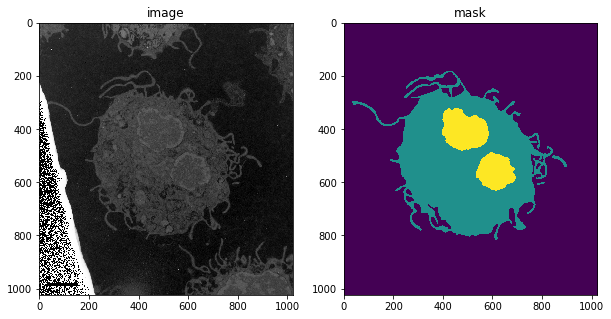

1 torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([3, 1024, 1024])


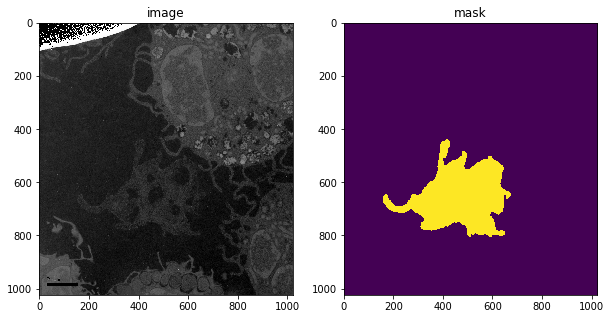

In [80]:
# test the traindataset class without transforms
train_data = TrainDataset(img_dir=img_dir, mask_dir = mask_dir)

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].size(), sample['mask'].size())
    print(sample['mask'])
    print(sample['image'].shape)
    plt.figure(figsize=(10, 5))
    show_mask(sample['image'].permute(1,2,0),sample['mask'])
    
    if i == 1:  
        break

#### Resize both the images and mask 

The original image:


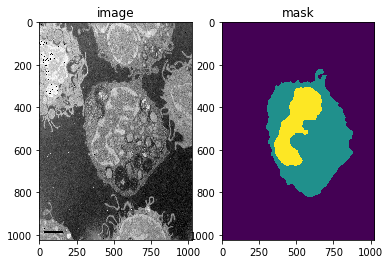

The rescaled image:
torch.Size([3, 128, 128])
<class 'torch.Tensor'>


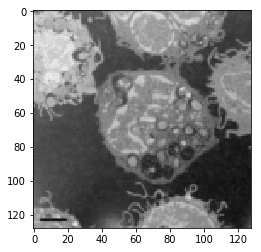

The rescaled mask:
torch.Size([1, 128, 128])
<class 'torch.Tensor'>
torch.Size([128, 128])


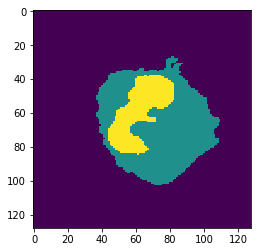

In [81]:
compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((128,128)), transforms.ToTensor()])

fig = plt.figure()
sample = train_data[3]

print("The original image:")
show_mask(sample['image'].permute(1,2,0),sample['mask'])


print("The rescaled image:")
rescaled_image = compose(sample['image'])
print(rescaled_image.size())
print(type(rescaled_image))
plt.imshow(rescaled_image.permute(1,2,0))
plt.pause(0.5)

print('The rescaled mask:')

rescaled_mask = compose(torch.unsqueeze(sample['mask'],dim=0))
print(rescaled_mask.size())
print(type(rescaled_mask))
print(rescaled_mask.squeeze().size())
plt.imshow(rescaled_mask.squeeze())

In [82]:
compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((128,128)), transforms.ToTensor()])
transformed_dataset = TrainDataset(img_dir=img_dir, mask_dir = mask_dir, transform = compose)

torch.Size([3, 128, 128])
<class 'torch.Tensor'>
The image is:


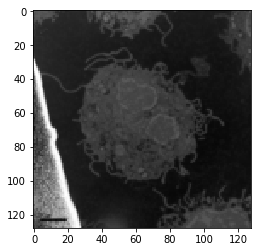

torch.Size([128, 128])
<class 'torch.Tensor'>
torch.Size([128, 128])
The mask is:


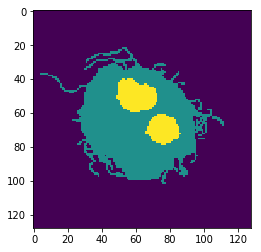

torch.Size([3, 128, 128])
<class 'torch.Tensor'>
The image is:


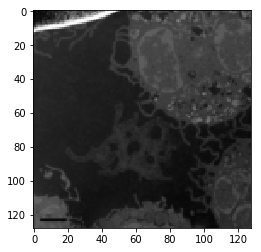

torch.Size([128, 128])
<class 'torch.Tensor'>
torch.Size([128, 128])
The mask is:


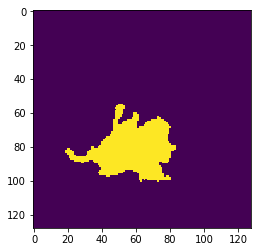

torch.Size([3, 128, 128])
<class 'torch.Tensor'>
The image is:


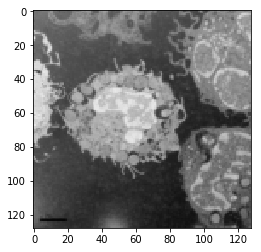

torch.Size([128, 128])
<class 'torch.Tensor'>
torch.Size([128, 128])
The mask is:


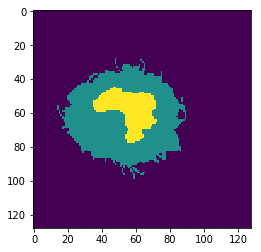

In [83]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(sample['image'].size())
    print(type(sample['image']))
    print('The image is:')
    plt.imshow(sample['image'].permute(1,2,0))
    plt.pause(0.5)
    
    print(sample['mask'].size())
    print(type(sample['mask']))
    print(sample['mask'].squeeze().size())
    print('The mask is:')
    plt.imshow(sample['mask'].squeeze())
    plt.pause(0.5)
    if i == 2:  
        break

In [84]:
dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle = False, num_workers = 4)

In [85]:
print(len(dataloader))

43


In [86]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    print(sample_batched['image'].size())
    if i_batch ==0:
        break

0
torch.Size([1, 3, 128, 128])


In [87]:
class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

In [88]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size,
                                   padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x

In [89]:
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels,
                 kernel_size, padding, stride):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


In [90]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size,
                 padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size,
                                  padding, stride)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size,
                              padding, stride)

        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size,
                              padding, stride)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size,
                              padding, stride)
        
        self.down4 = DownConv(8 * out_channels, 16 * out_channels, kernel_size,
                              padding, stride)
        
        self.up4 = UpConv(16 * out_channels, 8 * out_channels, 8 * out_channels,
                          kernel_size, padding, stride)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,
                          kernel_size, padding, stride)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels,
                          kernel_size, padding, stride)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels,
                          kernel_size, padding, stride)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        # Decoder
        x_up = self.up4(x4, x3)
        x_up = self.up3(x_up, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
#         x_out = F.log_softmax(self.out(x_up), 1)
        x_out = self.out(x_up)
        return x_out

In [91]:
unet = UNet(in_channels=3,
             out_channels=64,
             n_class=3,
             kernel_size=3,
             padding=1,
             stride=1)

In [92]:
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

UNet(
  (init_conv): BaseConv(
    (act): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down1): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (down2): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (down3): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block)

In [93]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [94]:
torch.cuda.device_count()

1

In [95]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [96]:
unet = unet.to(device)

In [97]:
print(unet_params[0].dtype)

torch.float32


In [98]:
for i_batch, sample_batched in enumerate(dataloader):
    
    # Prepare the data
    inputs, mask = sample_batched['image'], sample_batched['mask']
   
    print("The inputs is: ")
    print(inputs)
    print(inputs.size())
    
    print('\n The groundtruth label is: ')
    print(mask)
    print(mask.size())
    
    inputs = inputs.to(device)
   
    outputs = unet(inputs)
    print("\n The output score is: ")
    print(outputs)
    print(outputs.size())

    
    if i_batch == 0:
        
        break

The inputs is: 
tensor([[[[0.3765, 0.3490, 0.3412,  ..., 0.2392, 0.2392, 0.3333],
          [0.3412, 0.3176, 0.3373,  ..., 0.2667, 0.2784, 0.3333],
          [0.3020, 0.3216, 0.3333,  ..., 0.2627, 0.2824, 0.2667],
          ...,
          [0.2902, 0.2941, 0.2980,  ..., 0.3176, 0.2902, 0.2588],
          [0.2353, 0.3020, 0.2627,  ..., 0.2941, 0.3059, 0.2627],
          [0.2353, 0.3098, 0.2667,  ..., 0.2667, 0.2902, 0.2549]],

         [[0.3765, 0.3490, 0.3412,  ..., 0.2392, 0.2392, 0.3333],
          [0.3412, 0.3176, 0.3373,  ..., 0.2667, 0.2784, 0.3333],
          [0.3020, 0.3216, 0.3333,  ..., 0.2627, 0.2824, 0.2667],
          ...,
          [0.2902, 0.2941, 0.2980,  ..., 0.3176, 0.2902, 0.2588],
          [0.2353, 0.3020, 0.2627,  ..., 0.2941, 0.3059, 0.2627],
          [0.2353, 0.3098, 0.2667,  ..., 0.2667, 0.2902, 0.2549]],

         [[0.3765, 0.3490, 0.3412,  ..., 0.2392, 0.2392, 0.3333],
          [0.3412, 0.3176, 0.3373,  ..., 0.2667, 0.2784, 0.3333],
          [0.3020, 0.3216,

### Define the loss function and learning rate

In [99]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.05

In [101]:
for epoch in range(20):
    # loop over the dataset 1 times
    
    running_loss = 0.0
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    optimizer = optim.SGD(unet.parameters(), lr=my_lr)
    for i_batch, sample_batched in enumerate(dataloader):
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['mask']
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs)

        # Define the loss
        loss = criterion(outputs, labels.long()) 
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()

        if i_batch%43 == 42: 
            # print every 5 mini-batchs
            print('[%d, %5f] loss: %.5f'%(epoch +1, i_batch+1, running_loss/43))
            running_loss = 0.0
print('Finish Training')

[1, 43.000000] loss: 0.04249
[2, 43.000000] loss: 0.01249
[3, 43.000000] loss: 0.00684
[4, 43.000000] loss: 0.00461
[5, 43.000000] loss: 0.00345
[6, 43.000000] loss: 0.00274
[7, 43.000000] loss: 0.00227
[8, 43.000000] loss: 0.00193
[9, 43.000000] loss: 0.00168
[10, 43.000000] loss: 0.00149
[11, 43.000000] loss: 0.00137
[12, 43.000000] loss: 0.00130
[13, 43.000000] loss: 0.00124
[14, 43.000000] loss: 0.00118
[15, 43.000000] loss: 0.00114
[16, 43.000000] loss: 0.00111
[17, 43.000000] loss: 0.00109
[18, 43.000000] loss: 0.00107
[19, 43.000000] loss: 0.00105
[20, 43.000000] loss: 0.00104
Finish Training


torch.Size([3, 128, 128])
<class 'torch.Tensor'>
The image is:


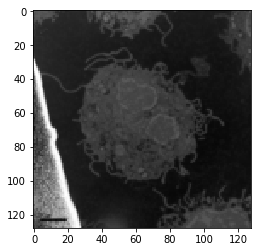

torch.Size([128, 128])
<class 'torch.Tensor'>
torch.Size([128, 128])
The mask is:


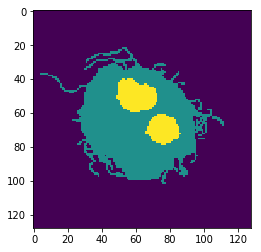

In [102]:
sample = transformed_dataset[0]
print(sample['image'].size())
print(type(sample['image']))
print('The image is:')
plt.imshow(sample['image'].permute(1,2,0))
plt.pause(0.5)
    
print(sample['mask'].size())
print(type(sample['mask']))
print(sample['mask'].squeeze().size())
print('The mask is:')
plt.imshow(sample['mask'].squeeze())


In [105]:
output= unet(sample['image'].unsqueeze(dim=0).to(device))

torch.Size([128, 128, 3])


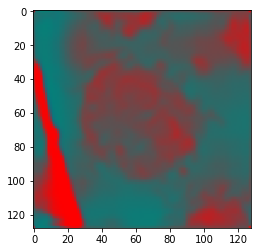

In [139]:
output = output.cpu().detach()
print(output.size())
plt.imshow(torch.exp(output))